In [1]:
'''
This is the file for SHAP analysis on image NN
We'll firstly train a self-constructed CNN and then perform SHAP analysis on it. 
'''
# General packages
import pandas as pd
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
import random

from matplotlib.image import imread
import cv2

# Packages for ML
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
# from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from tensorflow.keras.optimizers import Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D, AveragePooling2D

import shap

In [3]:
fd = 'IDC_regular_ps50_idx5'

imagePatches = glob(fd + '/**/*.png', recursive=True)
for filename in imagePatches[0:5]:
    print(filename)

IDC_regular_ps50_idx5/14189/0/14189_idx5_x751_y801_class0.png
IDC_regular_ps50_idx5/14189/0/14189_idx5_x2751_y1151_class0.png
IDC_regular_ps50_idx5/14189/0/14189_idx5_x651_y1201_class0.png
IDC_regular_ps50_idx5/14189/0/14189_idx5_x1251_y1551_class0.png
IDC_regular_ps50_idx5/14189/0/14189_idx5_x2601_y1151_class0.png


In [4]:
len(imagePatches)

277524

In [5]:
# bin the data to cancer and no cancer

class0 = [] # 0 = no cancer
class1 = [] # 1 = cancer

for filename in imagePatches:
    if filename.endswith("class0.png"):
         class0.append(filename)
    else:
        class1.append(filename)

display('Size of the class 0 = ',len(class0))
display('Size of the class 1 = ',len(class1))

'Size of the class 0 = '

198738

'Size of the class 1 = '

78786

In [6]:
class0[100]

'IDC_regular_ps50_idx5/14189/0/14189_idx5_x801_y1051_class0.png'

In [7]:
# randomly select 1000 images from each class

num_sample_selected = 25000
rand_sample_class0 = random.sample(class0, num_sample_selected)
rand_sample_class1 = random.sample(class1, num_sample_selected)


In [8]:
rand_sample_class1[100]

'IDC_regular_ps50_idx5/12906/1/12906_idx5_x2351_y2001_class1.png'

In [9]:
def get_image_arrays(data, label):
    img_arrays = []
    for i in data:
        if i.endswith('.png'):
            img = imread(i )
            img_sized = cv2.resize(img, (64, 64), interpolation=cv2.INTER_LINEAR)
            img_arrays.append([img_sized, label])
    return img_arrays

In [10]:
class0_array = get_image_arrays(rand_sample_class0, 0)
class1_array = get_image_arrays(rand_sample_class1, 1)

In [11]:
len(class0_array)

25000

(50, 50, 3)

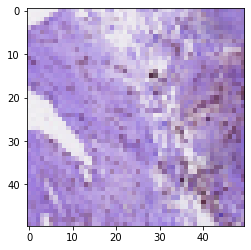

In [12]:
test = cv2.imread(fd + '/13689/1/13689_idx5_x801_y1501_class1.png' ,cv2.IMREAD_COLOR)
plt.imshow(test)

display(test.shape)

In [13]:
# combine the class 0 and class 1 data
combined_data = np.concatenate((class0_array, class1_array))

# array of index for shuffling
idx_arr = list(range(combined_data.shape[0]))

random.seed(10)

random.shuffle(idx_arr)

# shuffled data
combined_data = combined_data[idx_arr,:]

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [15]:
X = []
y = []


for i in range(combined_data.shape[0]):
    X.append(combined_data[i][0])
    y.append(combined_data[i][1])

In [16]:
X = np.array(X).reshape(-1, 64, 64, 3)

In [17]:
print(torch.cuda.is_available())

True


In [18]:
X.shape

(50000, 64, 64, 3)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(37500, 64, 64, 3) (12500, 64, 64, 3) (37500, 2) (12500, 2)


In [20]:
# Try different network sturctures 
def model_1():        
    model = Sequential()
    model.add(Conv2D(filters = 64, kernel_size=3, activation='relu', input_shape=(64,64,3)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 32, kernel_size=3, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 16, kernel_size=3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.25))
    model.add(Dense(2, activation="softmax"))
    adam = Adam(learning_rate=0.0001)
    model.compile(loss="binary_crossentropy", optimizer=adam, metrics=['accuracy'])   
    #model.compile(loss="MeanSquaredError", optimizer=adam, metrics=['accuracy'])     


    return model

def model_2():        
    model = Sequential()
    model.add(Conv2D(filters = 16, kernel_size=3, activation='relu', input_shape=(64,64,3)))
    model.add(Dropout(0.25))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(filters = 32, kernel_size=3, activation='relu'))
    model.add(Dropout(0.25))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(filters = 64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.25))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation="softmax"))
    model.add(Dense(2, activation="softmax"))
    adam = Adam(learning_rate=0.0001)
    model.compile(loss="binary_crossentropy", optimizer=adam, metrics=['accuracy'])   
    #model.compile(loss="MeanSquaredError", optimizer=adam, metrics=['accuracy'])     


    return model

def model_3():        
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size=3, activation='relu', input_shape=(64,64,3)))
    model.add(Conv2D(filters = 32, kernel_size=3, activation='relu'))
    model.add(AveragePooling2D((2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters = 64, kernel_size=3, activation='relu'))
    model.add(Conv2D(filters = 64, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    
    #model.add(Conv2D(filters = 64, kernel_size=3, activation='relu'))
    #model.add(Conv2D(filters = 64, kernel_size=3, activation='relu'))
    #model.add(MaxPooling2D((2, 2)))
    #model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation="softmax"))
    adam = Adam(learning_rate=0.0001)
    model.compile(loss="binary_crossentropy", optimizer=adam, metrics=['accuracy'])   
    #model.compile(loss="MeanSquaredError", optimizer=adam, metrics=['accuracy'])     


    return model

In [21]:
model = model_3()

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs= 20,
    verbose = 1,
)

2022-05-30 11:52:07.755432: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-30 11:52:12.507215: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6704 MB memory:  -> device: 0, name: GeForce GTX 1080, pci bus id: 0000:84:00.0, compute capability: 6.1
2022-05-30 11:52:12.802475: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1843200000 exceeds 10% of free system memory.
2022-05-30 11:52:15.262650: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1843200000 exceeds 10% of free system memory.
2022-05-30 11:52:16.698828: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimizati

Epoch 1/20


2022-05-30 11:52:18.638226: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2022-05-30 11:52:19.626722: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-30 11:52:19.627961: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-30 11:52:19.628029: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2022-05-30 11:52:19.629207: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-30 11:52:19.629423: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1172/1172 [==============================] - 19s 12ms/step - loss: 0.4897 - accuracy: 0.7735 - val_loss: 0.4433 - val_accuracy: 0.8042
Epoch 2/20
1172/1172 [==============================] - 13s 11ms/step - loss: 0.4473 - accuracy: 0.8018 - val_loss: 0.4289 - val_accuracy: 0.8102
Epoch 3/20
1172/1172 [==============================] - 13s 11ms/step - loss: 0.4331 - accuracy: 0.8085 - val_loss: 0.4208 - val_accuracy: 0.8187
Epoch 4/20
1172/1172 [==============================] - 13s 11ms/step - loss: 0.4229 - accuracy: 0.8135 - val_loss: 0.4015 - val_accuracy: 0.8238
Epoch 5/20
1172/1172 [==============================] - 13s 11ms/step - loss: 0.4128 - accuracy: 0.8184 - val_loss: 0.4340 - val_accuracy: 0.8084
Epoch 6/20
1172/1172 [==============================] - 13s 11ms/step - loss: 0.4047 - accuracy: 0.8228 - val_loss: 0.4157 - val_accuracy: 0.8188
Epoch 7/20
1172/1172 [==============================] - 13s 11ms/step - loss: 0.3979 - accuracy: 0.8271 - val_loss: 0.3803 - val_accura

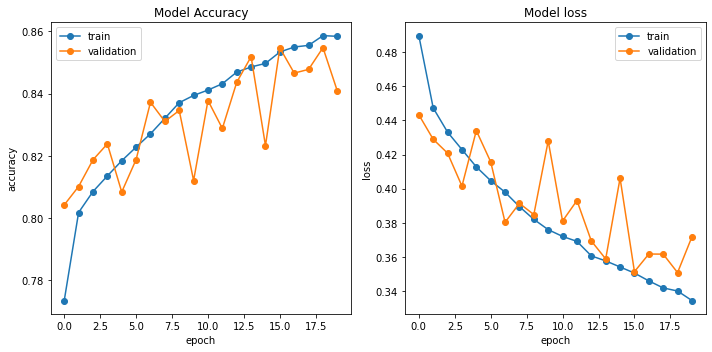

In [22]:
fig, axs = plt.subplots(1,3,figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'],'-o')
plt.plot(history.history['val_accuracy'],'-o')
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'],'-o')
plt.plot(history.history['val_loss'],'-o')
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

fig.tight_layout()
# plt.savefig('Self-CNN-result.png',dpi=300)
plt.show()

In [23]:
# confusion matrix
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

Y_test_preds = model.predict(X_test)
Y_test_preds = np.argmax(Y_test_preds, axis=1)
y_test_binary = np.argmax(y_test,axis=1)
class_labels = ['B','M']
print("Test Accuracy : {}".format(accuracy_score(y_test_binary, Y_test_preds)))
print("\nConfusion Matrix : ")
print(confusion_matrix(y_test_binary, Y_test_preds))
print("\nClassification Report :")
print(classification_report(y_test_binary, Y_test_preds, target_names=class_labels))



Test Accuracy : 0.8408

Confusion Matrix : 
[[4996 1369]
 [ 621 5514]]

Classification Report :
              precision    recall  f1-score   support

           B       0.89      0.78      0.83      6365
           M       0.80      0.90      0.85      6135

    accuracy                           0.84     12500
   macro avg       0.85      0.84      0.84     12500
weighted avg       0.85      0.84      0.84     12500



In [25]:
# Try SHAP on this model
shap.initjs()
# inpaint_ns, blur(28,28), inpaint_telea
masker = shap.maskers.Image("blur(3,3)", X_train[0].shape)

explainer = shap.Explainer(model, masker, output_names=class_labels)

In [26]:
classes = np.unique(y_test_binary)
mapping = dict(zip(classes, class_labels))

In [27]:
X_test.shape

(12500, 64, 64, 3)

In [111]:
# correct/wrong predictions
wrong_preds_idx = np.argwhere(y_test_binary!=Y_test_preds)
correct_preds_idx = np.argwhere(y_test_binary==Y_test_preds)

sample_num = 1000
X_batch_wrong = X_test[wrong_preds_idx.flatten()[:sample_num]]
Y_batch_wrong = y_test_binary[wrong_preds_idx.flatten()[:sample_num]]
X_batch_correct = X_test[correct_preds_idx.flatten()[:sample_num]]
Y_batch_correct = y_test_binary[correct_preds_idx.flatten()[:sample_num]]

In [29]:
X_batch_correct.shape

(1000, 64, 64, 3)

In [112]:
shap_values = explainer(X_batch_correct,outputs=shap.Explanation.argsort.flip[:2])
probs = model.predict(X_batch_correct)

Partition explainer: 1001it [05:25,  2.98it/s]                          


In [164]:
max_vals = np.max(np.mean(abs(shap_values[:,:,:,:,0].values),axis=3),axis=(1,2))

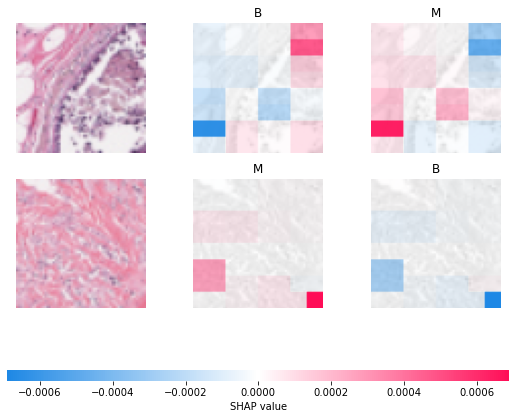

In [189]:
# Show 2 examples
shap.image_plot(shap_values[[94,915]],show=0)
# plt.savefig('SHAP-image.png',dpi=300)

In [ ]:
shap_values_wrong = explainer(X_batch_wrong, outputs=shap.Explanation.argsort.flip[:2])
probs_wrong = model.predict(X_batch_wrong)

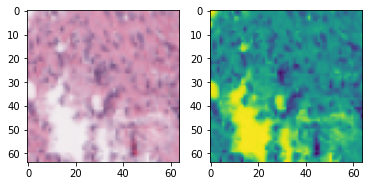

In [118]:
# Convert color image into gray ones
from skimage import color
plt.figure()
plt.subplot(1,2,1)
plt.imshow(shap_values[0,:,:,:,0].data)
grey_images = color.rgb2gray(shap_values[:,:,:,:,0].data)
plt.subplot(1,2,2)
plt.imshow(grey_images[0])

In [35]:
# compute different statistics from the image
# compute statistics of grey images
def piece_stat(imags,s): # s: side length of patch
    l = int(imags.shape[1]/s)
    N = imags.shape[0]
    var = np.zeros((N,l,l))
    mean = np.zeros((N,l,l))
    infor = np.zeros((N,l,l))
    for i in range(l):
        for j in range(l):
            var[:,i,j] = np.std(imags[:,i*s:(i+1)*s,j*s:(j+1)*s],axis=(1,2))
            mean[:,i,j] = np.mean(imags[:,i*s:(i+1)*s,j*s:(j+1)*s],axis=(1,2))
            infor[:,i,j] = my2Dinfor(imags[:,i*s:(i+1)*s,j*s:(j+1)*s])
    return var,mean,infor
# reduce shap value into patch values
def shap_val_reduce(shap_vals,s): 
    N = shap_vals.shape[0]
    l = int(shap_vals.shape[1]/s)
    reduced = np.zeros((N,l,l))
    for i in range(l):
        for j in range(l):
            reduced[:,i,j] = shap_vals[:,i*s,j*s]
    return reduced
# entropy (information) of 2-D gray patch
def my2Dinfor(imags):
    N = imags.shape[0]
    infor = np.zeros((N,))
    for i in range(N):
        arr = imags[i,:,:].flatten()
        nums = np.histogram(arr)[0]
        prob = nums/arr.shape[0]
        prob = prob[np.where(prob!=0)]
        infor[i] = np.sum(-prob*np.log2(prob))
    return infor

In [36]:
# entropy (information) of 2-D RGB patch
def color_infor(imags,s,nbins): # imags: num * l * l * 3 (rgb)
    l = int(imags.shape[1]/s)
    N = imags.shape[0]
    infor = np.zeros((N,l,l))
    for k in range(N):
        if k%50==0:print(k)
        for i in range(l):
            for j in range(l):
                inp = imags[k,i*s:(i+1)*s,j*s:(j+1)*s,:]
                inp = np.reshape(inp,(int(l*l),3))
                infor[k,i,j] = cal_color_infor(inp,nbins)
    return infor
def cal_color_infor(inp,nbins):
    H, edges = np.histogramdd(inp, bins=nbins, range=[(0,1)]*3)
    prob = H.flatten()/int(nbins**3)
    prob = prob[np.where(prob!=0)]
    infor = np.sum(-prob*np.log2(prob))
    return infor
    

In [132]:
infor_c = color_infor(shap_values[:,:,:,:,0].data,8,16)
infor_c_wrong = color_infor(shap_values_wrong[:,:,:,:,0].data,8,16)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


In [145]:
shap_vals = shap_val_reduce(np.mean(shap_values[:,:,:,:,0].values,axis=3),8)
shap_vals_wrong = shap_val_reduce(np.mean(shap_values_wrong[:,:,:,:,0].values,axis=3),8)

In [146]:
shap_vals[np.where(Y_batch_correct==0)[0],:,:] = shap_vals[np.where(Y_batch_correct==0)[0],:,:]*(-1.0)
shap_vals_wrong[np.where(Y_batch_wrong==0)[0],:,:] = shap_vals_wrong[np.where(Y_batch_wrong==0)[0],:,:]*(-1.0)

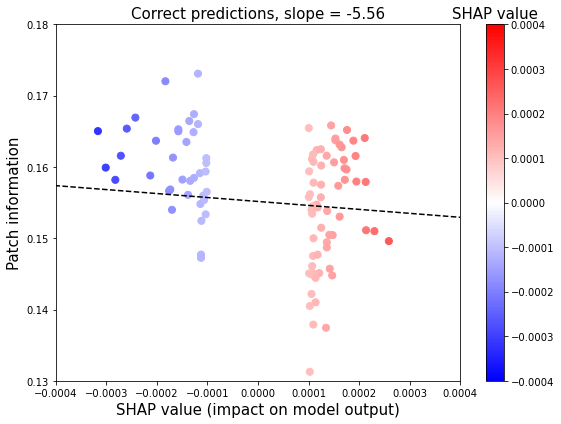

In [156]:
# correlation between SHAP value and entropy, in correct predictions 
val_to_plot = shap_vals
infor_to_plot = infor_c
filter_ind = np.where((abs(val_to_plot.flatten())>=1e-4))
#filter_ind = np.where(((shap_vals.flatten())>=1.2e-4))
plt.figure(figsize=(8,6))
plt.scatter(val_to_plot.flatten()[filter_ind],infor_to_plot.flatten()[filter_ind],c = val_to_plot.flatten()[filter_ind],
            cmap='bwr',s = 50)
clb=plt.colorbar()
plt.clim(-0.0004,0.0004)
clb.ax.tick_params(labelsize=10) 
clb.ax.set_title('SHAP value',fontsize=15)
plt.xlim([-0.0004,0.0004])
plt.ylim([0.13,0.18])
plt.xlabel('SHAP value (impact on model output)',fontsize=15)
plt.ylabel('Patch information',fontsize=15)
myfit = np.polyfit(val_to_plot.flatten()[filter_ind],infor_to_plot.flatten()[filter_ind],1)
xx = np.linspace(-0.0006,0.0006,100)
plt.plot(xx,np.polyval(myfit,xx),'k--')
plt.tight_layout()
plt.title('Correct predictions, slope = '+str(round(myfit[0],2)),fontsize=15)
# plt.savefig('SHAP-imagedata-correct.png',dpi=300)


In [ ]:
# correlation between SHAP value and entropy, in wrong predictions 
val_to_plot = shap_vals_wrong
infor_to_plot = infor_c_wrong
filter_ind = np.where((abs(val_to_plot.flatten())>=1e-4))
#filter_ind = np.where(((shap_vals.flatten())>=1.2e-4))
plt.figure(figsize=(8,6))
plt.scatter(val_to_plot.flatten()[filter_ind],infor_to_plot.flatten()[filter_ind],c = val_to_plot.flatten()[filter_ind],
            cmap='bwr',s = 50)
clb=plt.colorbar()
plt.clim(-0.0005,0.0005)
clb.ax.tick_params(labelsize=10) 
clb.ax.set_title('SHAP value',fontsize=15)
plt.xlim([-0.0005,0.0005])
plt.ylim([0.13,0.18])
plt.xlabel('SHAP value (impact on model output)',fontsize=15)
plt.ylabel('Patch information',fontsize=15)
myfit = np.polyfit(val_to_plot.flatten()[filter_ind],infor_to_plot.flatten()[filter_ind],1)
xx = np.linspace(-0.0006,0.0006,100)
plt.plot(xx,np.polyval(myfit,xx),'k--')
plt.tight_layout()
plt.title('Wrong predictions, slope = '+str(round(myfit[0],2)),fontsize=15)
# plt.savefig('SHAP-imagedata-correct.png',dpi=300)